In [24]:
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
import pytorch3d.ops
from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2
from tqdm import tqdm
from arguments import ModelParams, PipelineParams, ModelHiddenParams
from scene import Scene, GaussianModel
from gaussian_renderer import render, render_contrastive_feature, render_segmentation, render_mask
from segment_anything import (SamAutomaticMaskGenerator, SamPredictor, sam_model_registry)
from utils.sh_utils import SH2RGB
import imageio
from utils.segment_utils import *
from kmeans_pytorch import kmeans

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Hyper-parameters

In [2]:
FEATURE_DIM = 32

DATA_ROOT = './data/hypernerf/split-cookie'
# the model path, same to the --model_path in the training, after train_scene.py this folder will be created but named randomly
MODEL_PATH = './output/hypernerf/split-cookie'
GAUSSIAN_ITERATION = 14000

SAM_PROJ_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(GAUSSIAN_ITERATION)}/sam_proj.pt')
NEG_PROJ_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(GAUSSIAN_ITERATION)}/neg_proj.pt')
FEATURE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(GAUSSIAN_ITERATION)}/feature_point_cloud.ply')
SCENE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(GAUSSIAN_ITERATION)}/scene_point_cloud.ply')

SAM_ARCH = 'vit_h'
SAM_CKPT_PATH = '/data/sxj/dependencies/sam_ckpt/sam_vit_h_4b8939.pth'

## Data and Model Preparation

In [3]:
parser = ArgumentParser(description="Render script parameters")
model = ModelParams(parser, sentinel=True)
# op = OptimizationParams(parser)
pipeline = PipelineParams(parser)
hp = ModelHiddenParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
parser.add_argument('--mode', default='feature', choices=['scene', 'feature'])
parser.add_argument("--configs", type=str, default = "./arguments/hypernerf/default.py")
# parser.add_argument('--precomputed_mask', default=None, type=str)
args = get_combined_args(parser, MODEL_PATH, 'feature')
if args.configs:
    import mmcv
    from utils.params_utils import merge_hparams
    config = mmcv.Config.fromfile(args.configs)
    args = merge_hparams(args, config)

dataset = model.extract(args)
hyperparam = hp.extract(args)
dataset.need_features = True
dataset.need_gt_masks = True

gaussians = GaussianModel(dataset.sh_degree, args.mode, hyperparam, dataset.feature_dim)
scene = Scene(dataset, gaussians, load_iteration=args.iteration, mode=args.mode)

xyz = gaussians.get_xyz
point_features = gaussians.get_sam_features
# print(xyz.device)
# print(point_features.device)

Looking for config file in ./output/hypernerf/split-cookie/feature_cfg_args
Config file found at: ./output/hypernerf/split-cookie/feature_cfg_args
Feature Dimension:  32
mode:  feature
Loading trained model at iteration 14000
load finished


135it [00:00, 60475.39it/s]

format finished
Loading Training Cameras
Loading Test Cameras
Loading Video Cameras
Deformation Net Set aabb [14.73768902 10.22335386 67.65579987] [-24.60894775 -40.18284988   9.55506134]
Voxel Plane: set aabb= Parameter containing:
tensor([[ 14.7377,  10.2234,  67.6558],
        [-24.6089, -40.1828,   9.5551]])


loading model from exists./output/hypernerf/split-cookie/point_cloud/iteration_14000


## Load SAM

In [4]:
model_type = SAM_ARCH
sam = sam_model_registry[model_type](checkpoint=SAM_CKPT_PATH).to('cuda')
predictor = SamPredictor(sam)

## Begin Segmentation

In [5]:
bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
bg_color = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
bg_feature = [0 for i in range(FEATURE_DIM)]
bg_feature = torch.tensor(bg_feature, dtype=torch.float32, device="cuda")

video_cameras = [i for i in scene.getVideoCameras()]
cam_type = scene.dataset_type
print("There are",len(video_cameras),"views in the dataset.")

There are 539 views in the dataset.


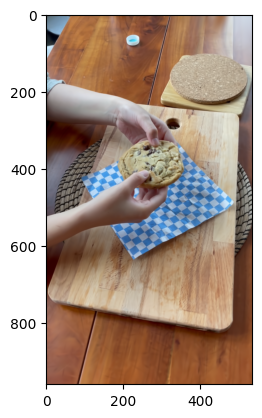

In [7]:
ref_img_camera_id = 0
mask_img_camera_id = 0
ref_view = video_cameras[ref_img_camera_id]

with torch.no_grad():
    rendering = render(ref_view, gaussians, pipeline, bg_color, cam_type=cam_type)["render"]
    img = to8b(rendering).transpose(1,2,0)
    # img = cv2.resize(img, dsize=(1024,1024), fx=1, fy=1, interpolation=cv2.INTER_LINEAR)
    plt.imshow(img)
    # plt.axis('off')
    plt.show()

In [13]:
with torch.no_grad():
    # predictor.set_image(img)
    # sam_feature = predictor.features
    # H, W = sam_feature.shape[-2:]
    # sam_feature = view.original_features

    rendered_feature = render_contrastive_feature(ref_view, gaussians, pipeline.extract(args), bg_feature)['render']
    H, W = rendered_feature.shape[-2:]
    rendered_feature = gaussians._mlp(rendered_feature.view(-1, H*W).permute([1, 0])).squeeze().permute([1,0]).reshape([-1, H, W])

# print("sam_features shape: ", sam_feature.shape)
print("rendered_feature shape: ", rendered_feature.shape)

rendered_feature shape:  torch.Size([64, 960, 536])


Visualize the SAM feature map and rendered feature map.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


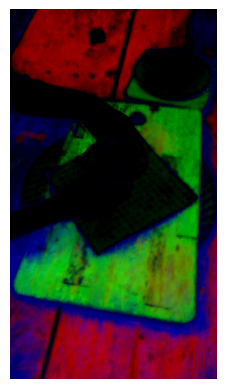

In [14]:
import numpy as np
from sklearn.decomposition import PCA

X = rendered_feature.permute([1, 2, 0]).flatten(0, 1).cpu().numpy()
np.random.seed(6)
pca = PCA(n_components=3)
pca.fit(X)
X_rgb = pca.transform(X).reshape(*rendered_feature.shape[-2:], 3)
plt.imshow(X_rgb)
plt.axis("off")
plt.show()

## Input Prompts

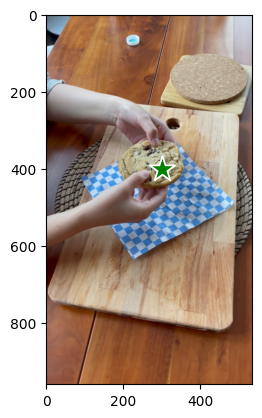

In [16]:
input_point = np.array([[300, 400]])
input_label = np.ones(len(input_point))

# plt.figure(figsize=(10,10))
plt.imshow(img)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

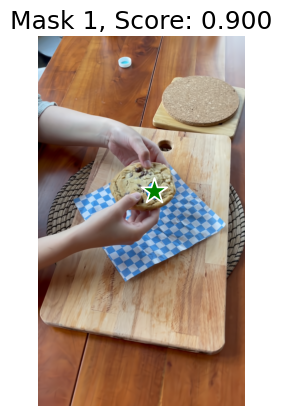

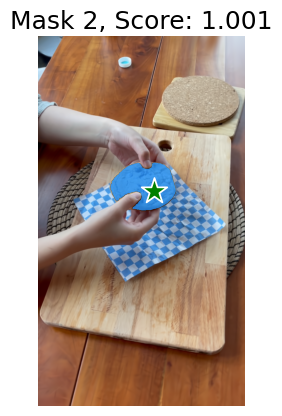

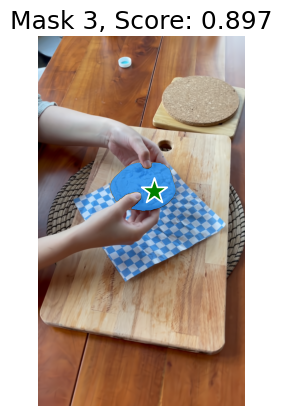

In [17]:
with torch.no_grad():
    predictor.set_image(img)
    vanilla_masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    
l = len(vanilla_masks)

for i, (mask, score) in enumerate(zip(vanilla_masks, scores)):
    plt.figure()
    # plt.subplot(1, l, i+1)
    plt.imshow(img)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

## Generate Average Pooled Feature Query

In [22]:
# mask_id = 0
mask_id = np.argmax(scores)
sam_mask = torch.tensor(vanilla_masks[mask_id]).float().cuda()

# Feature Field query
masked_features = sam_mask.unsqueeze(0) * rendered_feature
masked_features = masked_features.permute([1, 2, 0])
query = torch.nn.functional.normalize(masked_features.flatten(0, -2).mean(dim=0), dim=0)

In [45]:
def calc_feature_dist(embq, emb):
    dist = torch.norm(embq - emb.permute([1, 2, 0]), dim=-1)
    return dist

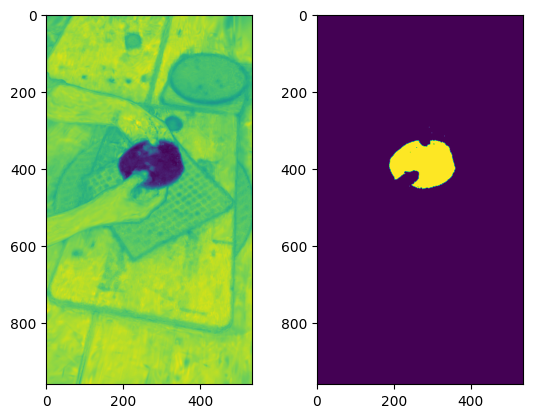

In [46]:
dist = calc_feature_dist(query, rendered_feature)
mask = dist < 0.8
plt.subplot(1, 2, 1)
plt.imshow(dist.detach().cpu())
plt.subplot(1, 2, 2)
plt.imshow(mask.detach().cpu())

In [ ]:
# K-means or not
# rendered_feature = render_contrastive_feature(ref_view, gaussians, pipeline.extract(args), bg_feature)['render']

# similarity = torch.cosine_similarity(mask_pooling_prototype.cuda(), rendered_feature.permute([1, 2, 0]), dim=-1)

similarity_mask = torch.einsum('C,CHW->HW', mask_pooling_prototype.cuda(), rendered_feature)
plt.imshow(similarity_mask.detach().cpu())
# similarity_mask = torch.nn.functional.interpolate(similarity_mask.float().unsqueeze(0).unsqueeze(0), (64,64), mode='bilinear').squeeze().cuda()
# similarity_mask = torch.sigmoid(similarity_mask)
similarity_mask[similarity_mask > 0] = 1
similarity_mask[similarity_mask != 1] = 0

# ref_mask = torch.nn.functional.interpolate(origin_ref_mask[None, None, :, :], (64, 64), mode='bilinear').squeeze().cuda()
# ref_mask[ref_mask > 0.5] = 1
# ref_mask[ref_mask != 1] = 0

iob = (similarity_mask * ref_mask).sum(dim = (-1, -2)) / ref_mask.sum()
print(iob.item())

if iob > 0.8:
    fmask_prototype = mask_pooling_prototype.unsqueeze(0)
else:
    # fmask_prototype = mask_pooling_prototype.unsqueeze(0)
    downsampled_masks = torch.nn.functional.adaptive_avg_pool2d(ref_mask.unsqueeze(0).unsqueeze(0), (8,8)).squeeze()
    downsampled_features = torch.nn.functional.adaptive_avg_pool2d(mask_low_dim_features.unsqueeze(0), (8,8)).squeeze(0)
    downsampled_features /= downsampled_masks.unsqueeze(0)

    downsampled_masks[downsampled_masks != 0]= 1
    init_prototypes = downsampled_features[:, downsampled_masks.bool()].permute([1,0])

    masked_sam_features = rendered_feature[:, origin_ref_mask.bool()]
    masked_sam_features = masked_sam_features.permute([1,0])
    
    num_clusters = init_prototypes.shape[0]
    print(num_clusters)
    
    if num_clusters <= 1:
        num_clusters = min(int(masked_sam_features.shape[0] ** 0.5), 32)
        init_prototypes = []

    cluster_ids_x, cluster_centers = kmeans(
        X=masked_sam_features, num_clusters=num_clusters, distance='cosine', device=torch.device('cuda')
    )

    similarity_mask = torch.sigmoid(torch.einsum('NC,CHW->NHW', cluster_centers.cuda(), rendered_feature))
    # similarity_mask = torch.nn.functional.interpolate(similarity_mask.float().unsqueeze(1), (64,64), mode='bilinear').squeeze().cuda()
    similarity_mask[similarity_mask >= 0.5] = 1
    similarity_mask[similarity_mask != 1] = 0
    similarity_mask = similarity_mask.squeeze()

    ioa = (similarity_mask * origin_ref_mask[None,:,:]).sum(dim = (-1, -2)) / (similarity_mask.sum(dim = (-1, -2)) + 1e-5)
    iob = (similarity_mask * origin_ref_mask[None,:,:]).sum(dim = (-1, -2)) / origin_ref_mask.sum()
    ioa = ioa.squeeze()
    iob = iob.squeeze()
    cluster_mask = ioa > 0.75

    # NMS
    for i in range(len(cluster_mask)):
        if not cluster_mask[i]:
            continue

        for j in range(i+1, len(cluster_mask)):
            if not cluster_mask[j]:
                continue

            if (similarity_mask[j] * similarity_mask[i]).sum() / ((similarity_mask[j] + similarity_mask[i]).sum() - (similarity_mask[j] * similarity_mask[i]).sum()) > 0.75:
                if ioa[i] > ioa[j]:
                    cluster_mask[j] = False
                else:
                    cluster_mask[i] = False
                    break
    
    cluster_centers = cluster_centers.cuda()
    cluster_centers = cluster_centers[cluster_mask, :]
    fmask_prototype = torch.cat([mask_pooling_prototype.unsqueeze(0), cluster_centers.cuda()], dim = 0)

## Get the initial segmentation through feature match.

In [55]:
def calc_feature_dist(embq, emb):
    dist = torch.norm(embq - emb, dim=-1)
    return dist

point_features = gaussians.get_sam_features
point_features = gaussians._mlp(point_features)

feature_dist = calc_feature_dist(query, point_features)
mask = feature_dist < 0.8
print("Total Gaussians Number: ", gaussians.get_xyz.shape[0])
print("Segmented Gaussians NUmber: ", torch.count_nonzero(mask).item())

Total Gaussians Number:  141444
Segmented Gaussians NUmber:  3804


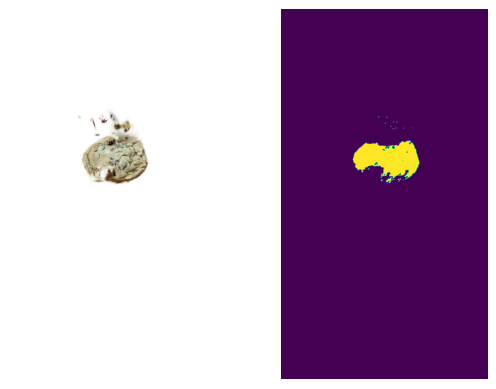

In [57]:
with torch.no_grad():
    target_seg = render_segmentation(ref_view, gaussians, pipeline, bg_color, mask)["render"]
    target_img_seg = to8b(target_seg.detach()).transpose(1,2,0)
    rendered_mask = render_mask(ref_view, gaussians, pipeline, bg_color, precomputed_mask=mask.float())["mask"]
    rendered_mask = rendered_mask.squeeze().detach().cpu() > 0.1

plt.subplot(1, 2, 1)
plt.imshow(target_img_seg)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(rendered_mask)
plt.axis("off")
plt.show()

In [16]:
with torch.no_grad():
    opacity = gaussians._opacity
    shs = gaussians.get_features
    means3D = gaussians.get_xyz
    scales = gaussians._scaling
    rotations = gaussians._rotation
    ts = torch.tensor(ref_view.time).to(means3D.device).repeat(means3D.shape[0],1)
    means3D_final, scales_final, rotations_final, opacity_final, shs_final = gaussians._deformation(means3D, scales, rotations, opacity, shs, ts)

selected_xyz = means3D_final[mask.cpu()].data
selected_score = point_scores[mask.cpu()]
selected_xyz, thresh, mask_ = postprocess_statistical_filtering(pcd=selected_xyz.clone(), precomputed_mask = mask.clone(), max_time=1)

In [17]:
with torch.no_grad():
    opacity = gaussians._opacity
    shs = gaussians.get_features
    means3D = gaussians.get_xyz
    scales = gaussians._scaling
    rotations = gaussians._rotation
    ts = torch.tensor(ref_view.time).to(means3D.device).repeat(means3D.shape[0],1)
    means3D_final, scales_final, rotations_final, opacity_final, shs_final = gaussians._deformation(means3D, scales, rotations, opacity, shs, ts)

selected_xyz = means3D_final[mask.cpu()].data
selected_score = point_scores[mask.cpu()]
# selected_xyz, thresh, mask_ = postprocess_statistical_filtering(pcd=selected_xyz.clone(), precomputed_mask = mask.clone(), max_time=1)
filtered_points, filtered_mask, thresh = postprocess_grad_based_statistical_filtering(pcd=selected_xyz.clone(), precomputed_mask=mask.clone(), 
                                                                                    gaussians=gaussians, view=ref_view, sam_mask=ref_mask.clone(), 
                                                                                    pipeline_args=pipeline.extract(args), bg_color=bg_color)
final_xyz, point_mask, final_normals = postprocess_growing(means3D_final, None, torch.from_numpy(filtered_points).cuda(), None, max(thresh, 0.05), grow_iter = 1)

save_dir = os.path.join(MODEL_PATH, "segmentation_res")
os.makedirs(save_dir, exist_ok=True)
# torch.save(point_mask, os.path.join(save_dir, 'seg_mask.pt'))
np.save(os.path.join(save_dir, 'means3d_ref.npy'), means3D_final.detach().cpu().numpy())
np.save(os.path.join(save_dir, 'point_mask.npy'), point_mask.detach().cpu().numpy())
np.save(os.path.join(save_dir, 'mask.npy'), mask.detach().cpu().numpy())
print(point_mask.count_nonzero())

tensor(5517, device='cuda:0')


In [58]:
final_mask = mask.float().detach().clone().unsqueeze(-1)
final_mask.requires_grad = True

background = torch.zeros(final_mask.shape[0], 3, device = 'cuda')
rendered_mask_pkg = render_mask(ref_view, gaussians, pipeline, bg_color, precomputed_mask=final_mask)

tmp_target_mask = torch.tensor(sam_mask, device=rendered_mask_pkg['mask'].device)
# tmp_target_mask = torch.nn.functional.interpolate(tmp_target_mask.unsqueeze(0).unsqueeze(0).float(), size=rendered_mask_pkg['mask'].shape[-2:] , mode='bilinear').squeeze(0)
# tmp_target_mask[tmp_target_mask > 0.5] = 1
# tmp_target_mask[tmp_target_mask != 1] = 0

loss = 30*torch.pow(tmp_target_mask - rendered_mask_pkg['mask'], 2).sum()
loss.backward()

grad_score = final_mask.grad.clone()
final_mask = final_mask - grad_score
final_mask[final_mask <= 0] = 0
final_mask[final_mask != 0] = 1
final_mask *= mask.unsqueeze(-1)
final_mask = final_mask.squeeze()
print(final_mask.count_nonzero())

tensor(3771, device='cuda:0')


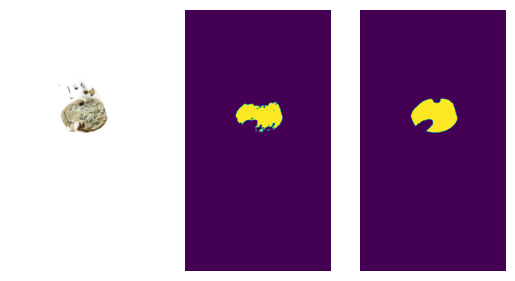

In [59]:
with torch.no_grad():
    target_seg = render_segmentation(ref_view, gaussians, pipeline, bg_color, final_mask.bool())["render"]
    target_img_seg = to8b(target_seg.detach()).transpose(1,2,0)
    rendered_mask = render_mask(ref_view, gaussians, pipeline, bg_color, precomputed_mask=final_mask.float())["mask"]
    rendered_mask = rendered_mask.squeeze().detach().cpu() > 0.1
    tmp_target_mask = tmp_target_mask.squeeze().detach().cpu()
plt.subplot(1, 3, 1)
plt.imshow(target_img_seg)
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(rendered_mask)
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(tmp_target_mask.int())
plt.axis('off')
plt.show()

## Generate refined segmentation video

In [60]:
from utils.segment_utils import *

render_images = []
for idx, view in enumerate(tqdm(video_cameras, desc="Rendering progress")):
    rendering = render_segmentation(view, gaussians, pipeline, bg_color, mask)["render"]
    render_images.append(to8b(rendering.detach()).transpose(1,2,0))

    torch.cuda.empty_cache()
    
imageio.mimwrite(os.path.join(MODEL_PATH, 'video', "ours_{}".format(GAUSSIAN_ITERATION), 'video_seg_2.mp4'), render_images, fps=30)

Rendering progress:   0%|          | 0/539 [00:00<?, ?it/s]

Rendering progress: 100%|██████████| 539/539 [00:03<00:00, 138.34it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (536, 960) to (544, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5987b40] Warning: data is not aligned! This can lead to a speed loss


## Quantative Results

In [61]:
test_views = [i for i in scene.getTestCameras()]

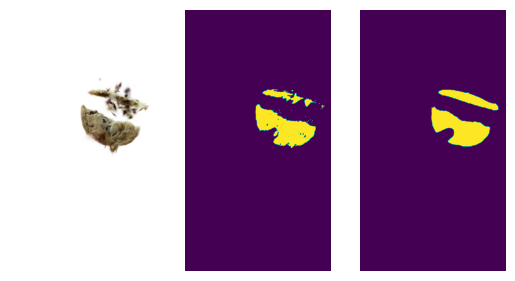

In [63]:
target_view = test_views[100]
with torch.no_grad():
    target_seg = render_segmentation(target_view, gaussians, pipeline, bg_color, mask.bool())["render"]
    target_img_seg = to8b(target_seg.detach()).transpose(1,2,0)
    rendered_mask = render_mask(target_view, gaussians, pipeline, bg_color, precomputed_mask=mask.float())["mask"]
    rendered_mask = rendered_mask.squeeze().detach().cpu() > 0.1
plt.subplot(1, 3, 1)
plt.imshow(target_img_seg)
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(rendered_mask)
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(target_view.gt_mask.squeeze().int())
plt.axis('off')
plt.show()

In [64]:
miou = 0.
macc = 0.
for idx, view in enumerate(tqdm(test_views)):
     #! render
     rendered_mask = render_mask(view, gaussians, pipeline, bg_color, precomputed_mask=mask.float())["mask"]
     rendered_mask = rendered_mask.squeeze().detach().cpu() > 0.1
     # rendered_mask = rendered_mask.int()

     gt_mask = view.gt_mask
     gt_mask = torch.nn.functional.interpolate(gt_mask.float()[None, ...], rendered_mask.shape[-2:], mode='bilinear')[0, 0, :, :].bool()
     
     #! metrics
     iou = (rendered_mask & gt_mask).sum() / (rendered_mask | gt_mask).sum()
     # iou += ((~rendered_mask) & (~gt_mask)).sum() / ((~rendered_mask) | (~gt_mask)).sum()
     # iou /= 2
     acc = (rendered_mask == gt_mask).count_nonzero() / gt_mask.numel()
     miou += iou
     macc += acc
     # print(miou)
     # break
     
     torch.cuda.empty_cache()

miou /= len(test_views)
macc /= len(test_views)
print("mIoU: %.4f" % (miou * 100))
print("mAcc: %.4f" % (macc * 100))

  0%|          | 0/134 [00:00<?, ?it/s]

100%|██████████| 134/134 [00:02<00:00, 53.80it/s]

mIoU: 73.7611
mAcc: 98.8915
